In [ ]:
import pandas as pd
import numpy as np
import re
import os
import torch
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from torch.utils.data import Dataset
import seaborn as sns

In [ ]:
file_name = "full_dataset.csv"
df = pd.read_csv(file_name)

In [ ]:
df

,Number,Date,City,Facts,Reasons,Judgment,Type,Label
0,٥٧١,١٠/٥/١٤٤٠,المدينة المنورة,تتلخص وقائع هذه الدعوى في أنه تقدم إلى المحكمة...,وحيث إن الواجب بحث الاختصاص القضائي قبل الخوض ...,أمين السرأيمن بن عبد العزيز الصبحي عضو إبراهيم...,الاجاره,مرفوضه
1,٤٥٣٠٠٩١٤٨٧,٢٨/٧/١٤٤٤,الدمام,تتلخص وقائع هذه الدعوى بالقدر اللازم لإصدار هذ...,لما كان النزاع بين المدعية والمدعى عليها ناشئ ...,حكمت الدائرة بما يلي : أولا / عدم جواز نظر طلب...,البيع,مرفوضه
2,٤٦٣٠٠٦٦٣٤٣,٢٢/١/١٤٤٦,جدة,تتلخص وقائع الدعوى بالقدر اللازم لإصدار الحكم ...,فبناء على ما تقدم ؛ وبما أن الدائرة تختص في نظ...,قررت الدائرة : قبول الطلب المدعي : ، وسماع شها...,الاجاره,مقبوله
3,٤٤٣٠٥٢٩٣٠٤,٥/٧/١٤٤٤,منطقة مكة المكرمة,تتلخص وقائع هذه الدعوى في أن المدعي يطلب إيداع...,وحيث اطلعت الدائرة على مرفقات القضية وحكم التح...,حكمت الدائرة : بقبول طلب إيداع حكم التحكيم الص...,البيع,مقبوله
4,١٧٥٨٤,٢٦/١٠/١٤٤١,الدمام,فقد ورد للدائرة قرار دائرة الاستئناف التجارية ...,بالاطلاع على ما ذكر تبين أن الدائرة أجابت عليه...,قررت الدائرة : إحالة القضية إلى دوائر الاستئنا...,البيع,مرفوضه
...,...,...,...,...,...,...,...,...
19817,٢٢٤٤/٣/ق,٢/٨/١٤٣٩,الدمام,تتحصل وقائع هذه القضية بالقدر اللازم لإصدار هذ...,وبعد سماع الدعوى والإجابة ، والاطلاع على أوراق...,برفض الدعوى المقامة من المدعي / (...) – هوية و...,نظر الدعوى,مرفوضه
19818,١٤٤٨٧/٣/ق,٤ / ٣ / ١٤٣٩,الدمام,تتحصل وقائع هذه الدعوى بالقدر اللازم لإصدار هذ...,وبعد سماع الدعوى والإجابة ، والاطلاع على أوراق...,) بإلزام (...) ويحمل الهوية الوطنية رقم (...) ...,نظر الدعوى,مقبوله
19819,١٧٧٢٠,٢٥ / ٢ / ١٤٣٩,الدمام,تتحصل وقائع هذه الدعوى بالقدر اللازم لإصدار ال...,وبعد سماع الدعوى والاطلاع على أوراق القضية ومس...,: بإلزام المدعى عليها / (...)- هوية وطنية (......,نظر الدعوى,مقبوله
19820,٩٦١٦/٣/ق,١٣ / ١ / ١٤٣٩,الدمام,تتحصل وقائع هذه الدعوى حسبما تفحص الأوراق في أ...,بعد سماع الدعوى والاطلاع على أوراق القضية ومست...,غيابيا بإلزام المدعى عليها / شركة (...) العربي...,نظر الدعوى,مقبوله


In [ ]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
encoder = LabelEncoder()
df["Encoded_Label"] = encoder.fit_transform(df["Label"])

In [ ]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Encoded_Label"])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df["Encoded_Label"])

In [ ]:
class LegalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512,
                 text_col="Facts", label_col="Encoded_Label"):
        self.data = dataframe.dropna(subset=[text_col, label_col]).reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_col = text_col
        self.label_col = label_col

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text  = str(self.data.loc[index, self.text_col])
        label = int(self.data.loc[index, self.label_col])


        enc = self.tokenizer(
            text,
            max_length=self.max_len,   
            truncation=True,
            padding=False,            
            return_attention_mask=True,
            return_tensors=None
        )

        return {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": label
        }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = LegalDataset(train_df, tokenizer, max_len=512)
val_dataset = LegalDataset(val_df, tokenizer, max_len=512)
test_dataset = LegalDataset(test_df, tokenizer, max_len=512)

In [ ]:
def print_dataset_details(dataset, name):
    print(f"\n{name} Dataset Details:")
    print(f"Number of samples: {len(dataset)}")
    print("\nSample from dataset:")
    sample = dataset[0]  
    print(f"Input IDs: {sample['input_ids']}")
    print(f"Attention Mask: {sample['attention_mask']}")
    print(f"Label: {sample['labels']}")
    print(f"Decoded Text: {tokenizer.decode(sample['input_ids'], skip_special_tokens=True)}")


print_dataset_details(train_dataset, "Train")
print_dataset_details(val_dataset, "Validation")
print_dataset_details(test_dataset, "Test")


Train Dataset Details:
Number of samples: 12685

Sample from dataset:
Input IDs: [0, 17746, 74269, 50868, 49773, 3070, 359, 57447, 34208, 1705, 36465, 359, 127510, 795, 103676, 2433, 70638, 676, 54484, 65, 97899, 906, 129382, 250, 248, 23216, 376, 6160, 826, 28698, 3247, 2567, 223299, 22327, 10488, 2689, 725, 8546, 359, 171373, 50910, 20121, 15434, 50, 207937, 227505, 20121, 15, 6, 69575, 69575, 78861, 80045, 78060, 86835, 69575, 86835, 76082, 6, 23198, 99025, 359, 57447, 34208, 10651, 86568, 2580, 608, 12037, 37674, 16218, 18296, 250, 14150, 221447, 60137, 27567, 45912, 240, 86606, 52909, 248, 6, 52909, 78861, 248, 47741, 69575, 69575, 67347, 176, 2044, 10651, 608, 6, 56413, 65, 97899, 906, 129382, 250, 23216, 376, 6160, 826, 28698, 3247, 2567, 223299, 22327, 10488, 2689, 6, 171373, 27602, 648, 20121, 15434, 207937, 227505, 20121, 15, 6, 69575, 69575, 78861, 80045, 78060, 86835, 69575, 86835, 76082, 1388, 26039, 14603, 28159, 10960, 906, 166275, 16947, 2000, 230, 177108, 608, 56719, 

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_score": f1_score(labels, preds, average="weighted"),  
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",       
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,
    warmup_ratio=0.06,
    metric_for_best_model="eval_loss",  
    greater_is_better=False,
    report_to=["none"],
    seed=42,
)

In [ ]:
trainer = Trainer(
    model=model,                       
    args=training_args,
    train_dataset=train_dataset,       
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  
)

/tmp/ipython-input-3881779249.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
train_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.477000,0.506656,0.757566,0.757016
2,0.572800,0.530586,0.780895,0.780814
3,0.525600,0.456785,0.784994,0.783776
4,0.480900,0.476214,0.787516,0.787467
5,0.397600,0.587384,0.779004,0.777784


In [ ]:
test_results = trainer.evaluate(test_dataset)

In [ ]:
test_results

{'eval_loss': 0.475314199924469,
 'eval_accuracy': 0.7737704918032787,
 'eval_f1_score': 0.7724105601811317,
 'eval_runtime': 20.8485,
 'eval_samples_per_second': 190.182,
 'eval_steps_per_second': 11.895,
 'epoch': 5.0}

In [ ]:
for k, v in test_results.items():
    if isinstance(v, (int, float)):
        print(f"{k}: {v:.4f}")

eval_loss: 0.4753
eval_accuracy: 0.7738
eval_f1_score: 0.7724
eval_runtime: 20.8485
eval_samples_per_second: 190.1820
eval_steps_per_second: 11.8950
epoch: 5.0000


              precision    recall  f1-score   support

           0     0.8240    0.6964    0.7549      1983
           1     0.7370    0.8512    0.7900      1982

    accuracy                         0.7738      3965
   macro avg     0.7805    0.7738    0.7724      3965
weighted avg     0.7805    0.7738    0.7724      3965



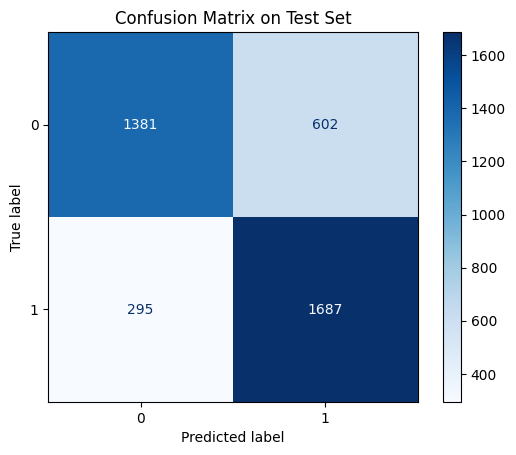

In [ ]:
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=1)

print(classification_report(y_true, y_pred, digits=4))


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()

In [ ]:
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")
prec = precision_score(y_true, y_pred, average="weighted")
rec  = recall_score(y_true, y_pred, average="weighted")

print(f"Accuracy : {acc:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")

Accuracy : 0.7738
F1-score : 0.7724
Precision: 0.7805
Recall   : 0.7738


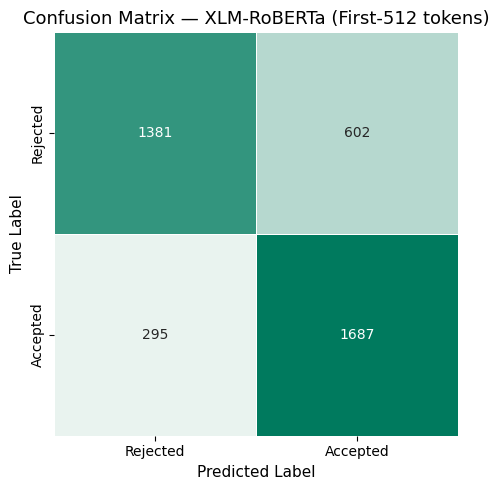

In [ ]:
class_labels = ["Rejected", "Accepted"]

def map_if_numeric(series):
    if pd.api.types.is_numeric_dtype(series):
        return pd.Series(series).map({0: "Rejected", 1: "Accepted"})
    return series

y_true_named = map_if_numeric(y_true)
y_pred_named = map_if_numeric(y_pred)

green_colors = sns.light_palette("#007A5E", as_cmap=True)


cm = confusion_matrix(y_true_named, y_pred_named, labels=class_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,        
    fmt="d",           
    cmap=green_colors, 
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar=False,
    linewidths=0.5,
    linecolor="white",
    square=True
)

plt.title("Confusion Matrix — XLM-RoBERTa (First-512 tokens)", fontsize=13)
plt.xlabel("Predicted Label", fontsize=11)
plt.ylabel("True Label", fontsize=11)

plt.tight_layout()
plt.savefig("confusion_matrix(XLM-RoBERTa).png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
test_results_df = test_df.copy()
test_results_df["True_Label"] = y_true
test_results_df["Predicted_Label"] = y_pred


probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
test_results_df["Prob_0"] = probs[:,0]
test_results_df["Prob_1"] = probs[:,1]

In [ ]:
test_results_df

,Number,Date,City,Facts,Reasons,Judgment,Type,Label,Encoded_Label,True_Label,Predicted_Label,Prob_0,Prob_1
16954,٤٤٧٢٦٦١٠٠,٢٩/١/١٤٤٤,الرياض,تتحصل وقائع هذه القضية بالقدر اللازم لإصدار هذ...,تأسيسا على ماجرى إيراده في الوقائع سالفة البيا...,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,مرفوضه,0,0,0,0.939526,0.060474
10708,٤٦٣٠١٨٥١٣٧,٩/٣/١٤٤٦,الرياض,تتلخص وقائع هذه الدعوى في أنه سبق أن تقدم المد...,وقد حصر وكيل المدعي طلبه في : إلزام المدعى علي...,فلكل ما تقدم ، حكمت المحكمة بــ : عدم اختصاص ا...,نظر الدعوى,مرفوضه,0,0,0,0.820972,0.179028
10347,٦٢٧٦,٣٠/٢/١٤٤٠,جدة,تتلخص الدعوى بالقدر اللازم للفصل فيها أن المدع...,ولما كان وكيل المدعي يطلب الحكم بإلزام المدعى ...,حكمت الدائرة أولا : بإلزام الشركة (…) سجل تجار...,الاجاره,مقبوله,1,1,1,0.123418,0.876582
9603,٤٣٣٢٢٦٧٢٣,٢٨/١٠/١٤٤٣,جدة,تتلخص وقائع هذه الدعوى في أنه سبق أن تقدم ممثل...,فبناء على ما تقدم من الدعوى والإجابة عنها وبعد...,حكمت الدائرة بإلزام المدعى عليه احمد بن محمد ب...,الاجاره,مقبوله,1,1,1,0.119819,0.880181
4940,٤١٩٠٣٥٤٨٩,١٠/٤/١٤٤٢,جدة,تتلخص وقائع هذه الدعوى بالقدر اللازم لإصدار ال...,وبعد استيفاء الدعوى لسائر أوضاعها الشكلية ، وب...,رفض الدعوى رقم ( ٩٧١ ) عام ١٤٤١هـ المقامة من /...,البيع,مرفوضه,0,0,0,0.580397,0.419603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7268,٤٤٣٠٩٥٠١٣٤,١١/١١/١٤٤٤,جدة,تتلخص وقائع هذه الدعوى في أنه سبق أن تقدمت وكي...,فبناء على ما تقدم ؛ وبما أن وكيل المدعى عليه ق...,حكمت الدائرة بعدم اختصاص المحكمة التجارية بجدة...,الاجاره,مرفوضه,0,0,1,0.378631,0.621369
16371,٤٤٣٠١٥٣٣٨٤,١٥/٣/١٤٤٤,المدينة المنورة,تتلخص وقائع الدعوى بالقدر اللازم للفصل فيها أن...,فبناء على ما تقدم من الدعوى والمرافعة ، ولأن ا...,عدم قبول الدعوى ؛ لما هو موضح بالأسباب ، وصلى ...,نظر الدعوى,مرفوضه,0,0,0,0.960731,0.039269
6205,٤٥٣٠٥٨٩٥٨٧,٦/٧/١٤٤٥,الدمام,تتحصل وقائع هذه الدعوى بالقدر اللازم لإصدار هذ...,تأسيسا على ما تقدم ، وبعد سماع الدعوى ، ولما ك...,بإلزام المدعى عليها / شركة أكواد للمصاعد ، سجل...,الاجاره,مقبوله,1,1,1,0.191252,0.808748
9511,٤٣٣٧٩١٢٨٨,١/١٢/١٤٤٣,جدة,تتحصل وقائع هذه الدعوى بالقدر الكافي لإصدار ال...,ولمــا كانت العلاقة بين الطرفين تتعلق بأتعاب م...,إلزام شركة بمكو العربية للمقاولات سجل تجاري (....,الاجاره,مقبوله,1,1,1,0.208340,0.791660


In [ ]:
test_results_df.to_csv("512XLM-RoBERTafirst512_predictions.csv", index=False)